# Introduction

This notebook explores an addition to the model free detection method.  Model free detection struggled during extended times of low irradiance.  This addition will filter periods of low irradiance based on the zscore.  For this method, a user must submit a number of days at a time so that zscoring can occur (here we use two weeks - it is unwise to use a very large time frame since seasonal affects may come affect filtering).

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free
import preprocess

from sklearn import linear_model

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings

%load_ext autoreload
%autoreload 2

# Setup

## Load data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 50] = 0 
    return data

In [3]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    # srrl_data = srrl_data.reindex(
    #     pd.date_range(start=srrl_data.index[0], end=srrl_data.index[-1], freq='1min')
    # ).fillna(0)
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 0] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    # print(srrl_data.index[0], srrl_data.index[-1])
    # print(srrl_data.index.date[0], srrl_data.index.date[-1])
    # print(srrl_data2.index[0], srrl_data2.index[-1])
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [4]:
def multi_scatter(clear_df, obsc_df, nrows, xs, ys, sharex=False, add_linreg=False):
    fig, axes = plt.subplots(nrows=nrows, figsize=(8, 2.5*nrows), sharex=sharex)
    clear = clear_df.replace([-np.inf, np.inf], np.nan).dropna()
    obsc = obsc_df.replace([-np.inf, np.inf], np.nan).dropna()
    for i, (x, y) in enumerate(zip(xs, ys)):
        ax = axes[i]
        ax.scatter(obsc[x], obsc[y], edgecolor='red', facecolor='none', alpha=.1)
        ax.scatter(clear[x], clear[y], edgecolor='green', facecolor='none', alpha=.1)
        if add_linreg:
            lm = linear_model.LinearRegression().fit(obsc[x].values.reshape(-1, 1), 
                                                     obsc[y].values.reshape(-1, 1))
            ax.plot(obsc[x], lm.predict(obsc[x].values.reshape(-1, 1)), c='orangered')
            r2_obsc = lm.score(obsc[x].values.reshape(-1, 1), 
                               obsc[y].values.reshape(-1, 1))
            lm = linear_model.LinearRegression().fit(clear[x].values.reshape(-1, 1), 
                                                     clear[y].values.reshape(-1, 1))
            ax.plot(clear[x], lm.predict(clear[x].values.reshape(-1, 1)), c='lightgreen')
            r2_clear = lm.score(clear[x].values.reshape(-1, 1), 
                                clear[y].values.reshape(-1, 1))
            print('{} vs {} r2_clear: {}, r2_obscured: {}'.format(x, y, r2_clear, r2_obsc))
        ax.set_xlabel(x)
        ax.set_ylabel(y)
    
    fig.tight_layout()

In [5]:
snl_data = load_snl()
# srrl_data = load_srrl()

## Set up PVLib systems

In [6]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [7]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [8]:
srrl_params = {'tilt': 40, 'elevation': 1828.8, 'azimuth': 180, 'lat': 39.742, 'lon': -105.18}
srrl = make_pvlib_sys(**srrl_params)

## Investigation

In [9]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-15')]

In [10]:
sample.index[0], sample.index[-1]

(Timestamp('2016-07-01 00:00:00-0700', tz='Etc/GMT+7', freq='T'),
 Timestamp('2016-07-14 23:59:00-0700', tz='Etc/GMT+7', freq='T'))

In [21]:
clear_skies = clearsky_detect_model_free.model_free_detect_meanval(sample)
# model_cs = rtc.get_clearsky(sample.index)
# model_cs = pd.Series(model_cs['ghi'], index=sample.index)
# clear_skies = pvlib.clearsky.detect_clearsky(sample, model_cs, sample.index, 10)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:296: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=index)
/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:151: RuntimeWarning: invalid value encountered in less_equal
  is_clear.iloc[midpoints] = (means <= metric_tol) & (data[midpoints] > 0.0)


In [22]:
properties = clearsky_detect_model_free.properties_calculator(sample, 30)

In [23]:
properties['time'] = properties.index
properties['min'] = properties['time'].apply(lambda x: np.abs(720 - (((60 * x.hour) + x.minute))))
properties.drop('time', axis=1, inplace=True)

In [24]:
properties.dropna(inplace=True)

In [25]:
properties['is_clear'] = clear_skies

In [26]:
properties_post_proc = properties.copy()

In [31]:
properties_post_proc['avg_derivative'] = np.abs(properties['avg_derivative'])
properties_post_proc['local_distances'] = np.log(properties['local_distances'])
properties_post_proc['local_integrals'] = np.log(properties['local_integrals'])
properties_post_proc['metric'] = np.log(properties['local_distances']) / np.log(properties['local_integrals'])

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


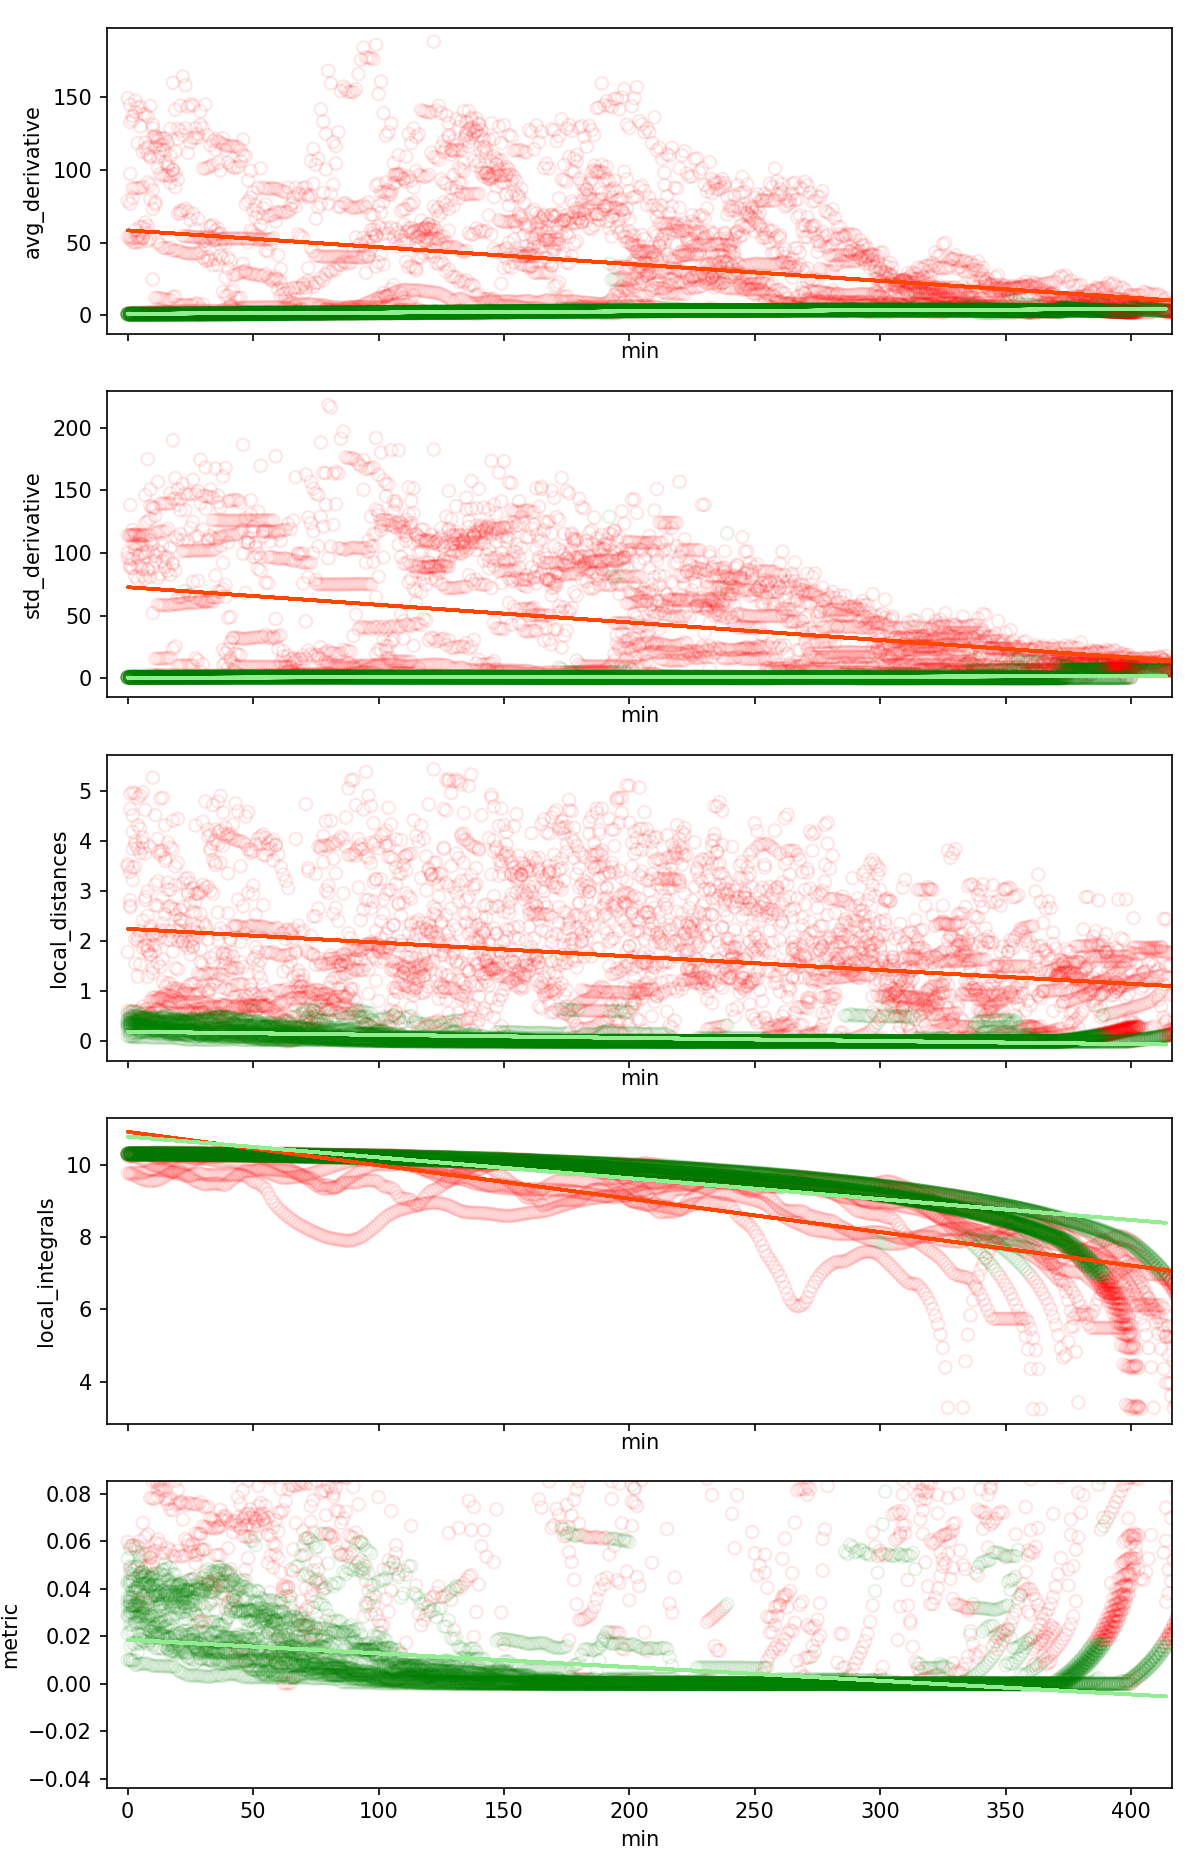

min vs avg_derivative r2_clear: 0.5140667905286564, r2_obscured: 0.15508504319338368
min vs std_derivative r2_clear: 0.01043817826906046, r2_obscured: 0.16660781739489416
min vs local_distances r2_clear: 0.2966586975903578, r2_obscured: 0.08493810475953023
min vs local_integrals r2_clear: 0.7790734008081001, r2_obscured: 0.6306198084424823
min vs metric r2_clear: 0.25880711329692685, r2_obscured: 0.026808007695093394


In [32]:
ys = ['avg_derivative', 'std_derivative', 'local_distances', 'local_integrals', 'metric']
xs = ['min'] * 5
multi_scatter(properties_post_proc[properties_post_proc['is_clear']],
              properties_post_proc[~properties_post_proc['is_clear']],
              len(ys), xs, ys, sharex=True, add_linreg=True)

<IPython.core.display.Javascript object>


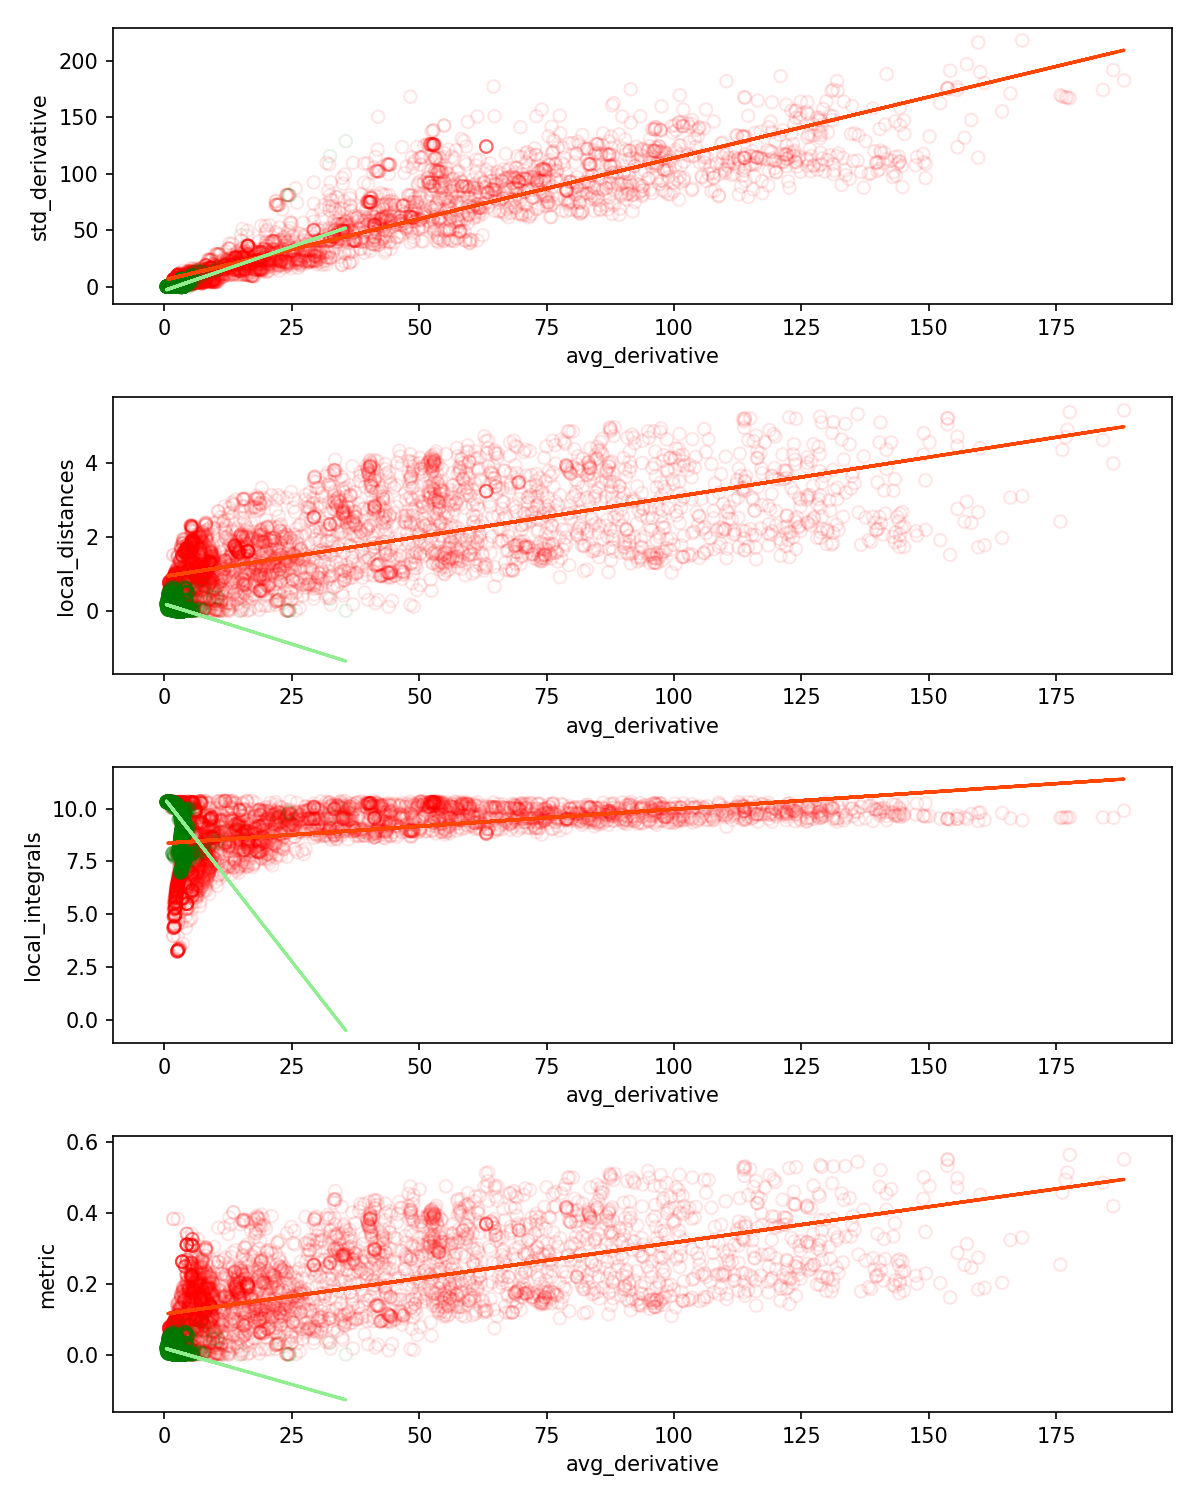

avg_derivative vs std_derivative r2_clear: 0.4002109281600982, r2_obscured: 0.8489367545078309
avg_derivative vs local_distances r2_clear: 0.18890619354836646, r2_obscured: 0.4525610292352278
avg_derivative vs local_integrals r2_clear: 0.28616631883631927, r2_obscured: 0.16631337113722977
avg_derivative vs metric r2_clear: 0.16722787557112417, r2_obscured: 0.3726323580761963


In [33]:
xs = ['avg_derivative', 'avg_derivative', 'avg_derivative', 'avg_derivative']
ys = ['std_derivative', 'local_distances', 'local_integrals', 'metric']
multi_scatter(properties_post_proc[properties_post_proc['is_clear']],
              properties_post_proc[~properties_post_proc['is_clear']],
              len(ys), xs, ys, sharex=False, add_linreg=True)

<IPython.core.display.Javascript object>


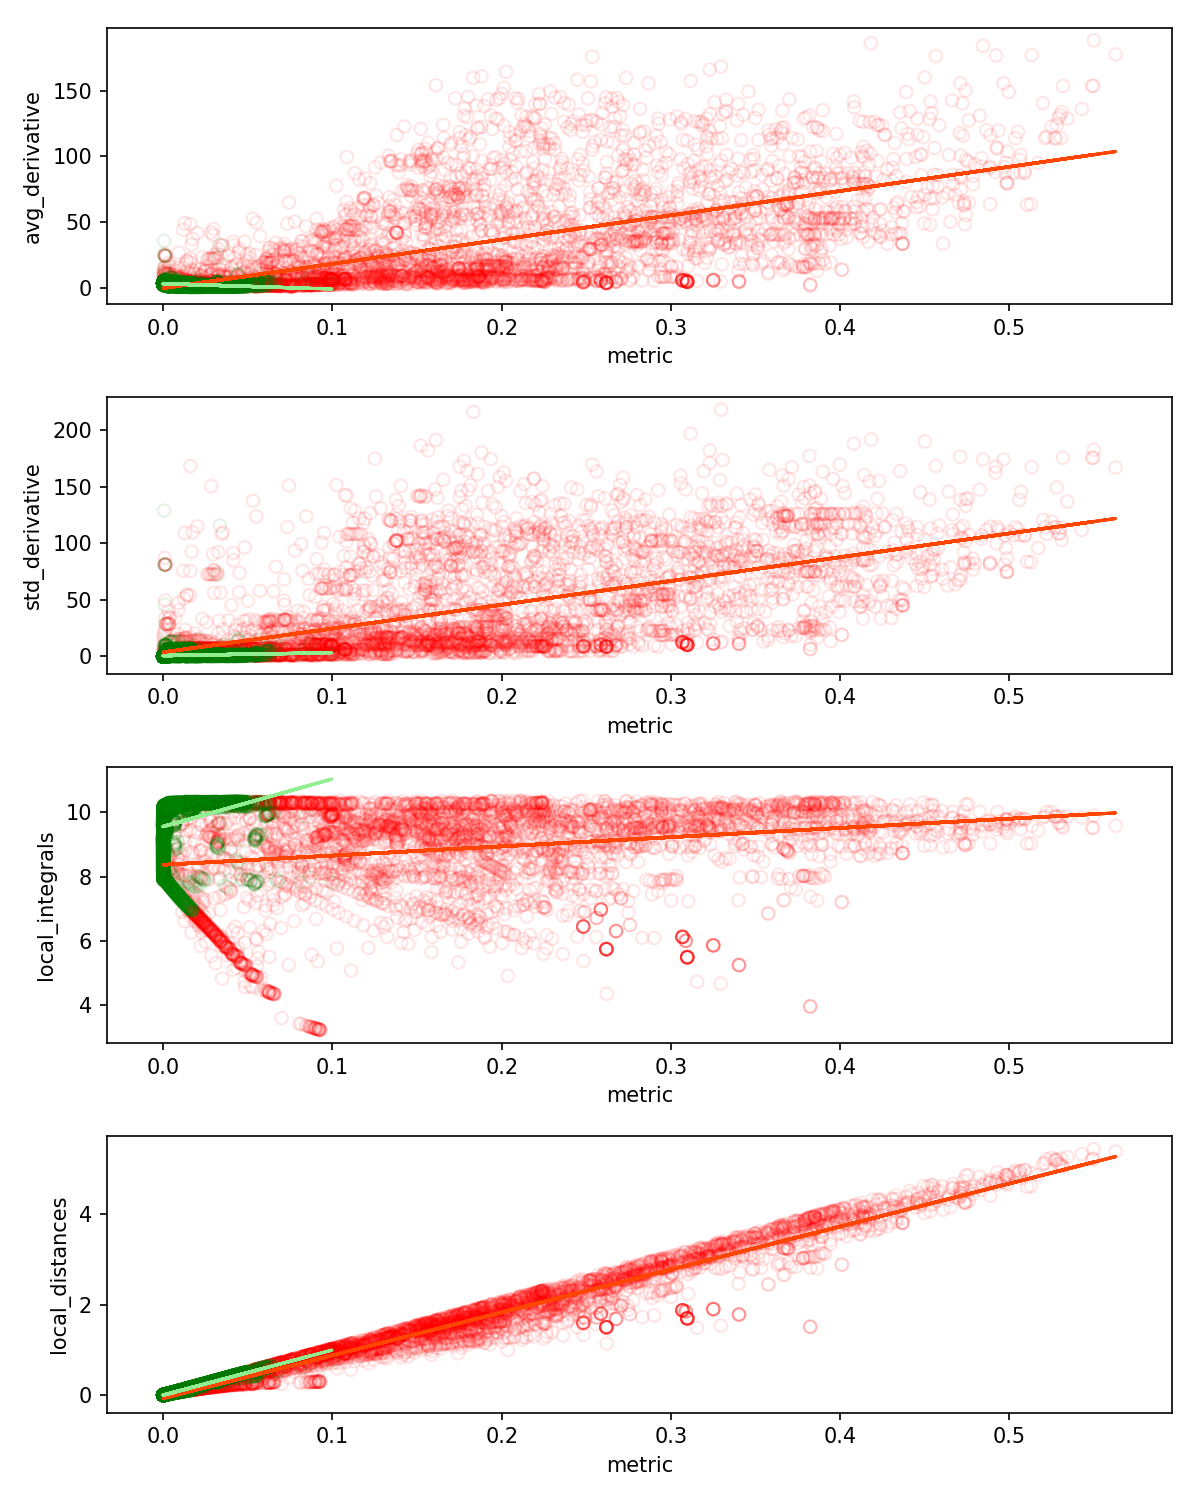

metric vs avg_derivative r2_clear: 0.16722787557112428, r2_obscured: 0.3726323580761964
metric vs std_derivative r2_clear: 0.010622136917313285, r2_obscured: 0.3501301173448904
metric vs local_integrals r2_clear: 0.06573963853575893, r2_obscured: 0.05694577332758366
metric vs local_distances r2_clear: 0.9927849884525479, r2_obscured: 0.9577701510517593


In [36]:
xs = ['metric', 'metric', 'metric', 'metric', 'metric']
ys = ['avg_derivative', 'std_derivative', 'local_integrals', 'local_distances']
multi_scatter(properties_post_proc[properties_post_proc['is_clear']],
              properties_post_proc[~properties_post_proc['is_clear']],
              len(ys), xs, ys, sharex=False, add_linreg=True)

<IPython.core.display.Javascript object>


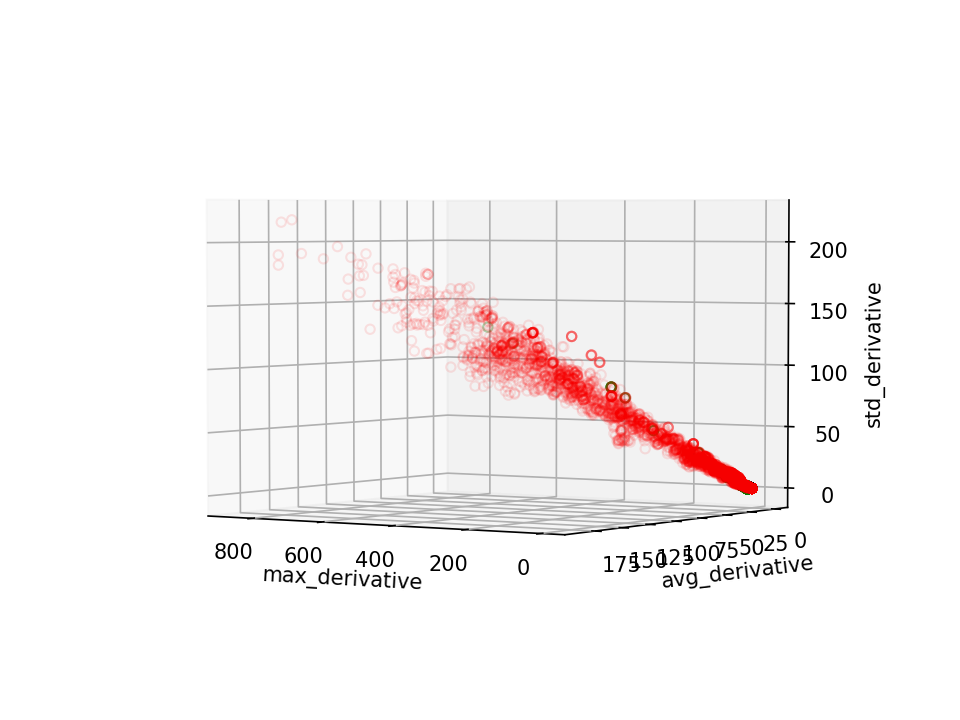

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

obscured_df = properties_post_proc[~properties_post_proc['is_clear']]
clear_df = properties_post_proc[properties_post_proc['is_clear']]


x = 'max_derivative'
y = 'avg_derivative'
z = 'std_derivative'
# y = 'std_derivative'

ax.scatter((obscured_df[x]),
           (obscured_df[y]),
           obscured_df[z], edgecolor='red', facecolor='none', alpha=.1, depthshade=False)

ax.scatter((clear_df[x]),
           (clear_df[y]),
           clear_df[z], edgecolor='green', facecolor='none')
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

# ax.view_init(15, 45)